## Functions

In [1]:
import pandas as pd
from skimage import io
import tifffile
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def getWindowRowColPairs(img, windowsize_r, windowsize_c):
  pairs = []
  for r in range(0, img.shape[0] - windowsize_r + 1, windowsize_r):
    for c in range(0, img.shape[1] - windowsize_c + 1, windowsize_c):
      pairs.append([r, c])
  return pairs

In [3]:
# Revserse the lists inside a list
def reverseElement(list_of_lists):
  reversed_list = []
  for xy in list_of_lists:
    x = xy[0]
    y = xy[1]
    reversed_list.append([y,x])
  return reversed_list

In [4]:
def calculateThreshold(ratio, origin_list):
  threshold_list = []
  for i in range(len(origin_list)):
    threshold = origin_list[i] * ratio[i % tiles_in_band]
    threshold_list.append(threshold)
  return threshold_list

In [5]:
# Add rectangles and texts to a image 
def addAnnotation(isSwapped, ax, xy, index, tiles, thresholds):
  color = 'y'
  if isSwapped:
    color = 'r'
    drawRect(ax, xy)
  addText(ax, xy, color, index, tiles, thresholds)

In [6]:
# Add text to the corresponding tile
def addText(ax, xy, color, index, tiles, thresholds):
  rx, ry = xy[0], xy[1]
  cx = rx + windowsize_c / 2.0
  cy = ry + windowsize_r / 2.0

  num = tiles[index] - avg_img_tiles[index]
  if num != 0:
    txt = str(int(tiles[index])) + '-' + str(int(avg_img_tiles[index])) + '\n(' + str(int(thresholds[index])) + ')'
    # ax.annotate(txt, (cx, cy), color=color, weight='bold', fontsize=10, ha='center', va='center')
  else:
    txt = str(int(avg_img_tiles[index]))
  ax.annotate(txt, (cx, cy), color=color, ha='center', va='center')

In [7]:
# Circle the rectangle of the corresponding tile
def drawRect(ax, xy):
  rect = patches.Rectangle(xy, windowsize_c, windowsize_r,
                          linewidth=3, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

In [8]:
# Collect the needed index based on the wanted bands
def selectWantedImage(selected_band, img):
  selected_img = np.array(img[:,:,selected_band])
  selected_img = np.reshape(selected_img, (selected_img.shape[0], selected_img.shape[1], 1))
  return selected_img

In [9]:
# Reshape the selected bands based on the number of channels
def plotImgMaskRegion(all_index_in_band, img, swapped_index, epiweek, tiles, thresholds):
  img = img.reshape(img.shape[0], img.shape[1])

  cloud_tiles = []
  intersection = list(set(all_index_in_band).intersection(swapped_index))
  difference = list(set(all_index_in_band) - set(swapped_index))

  # Create figure and axes
  fig, ax = plt.subplots(constrained_layout=True)
  ax.axis('off')
  ax.imshow(img, cmap='gray')

  for index in intersection:
    i = index % tiles_in_band
    xy = xy_pairs[i]
    addAnnotation(True, ax, xy, index, tiles, thresholds)

  for index in difference:
    i = index % tiles_in_band
    xy = xy_pairs[i]
    addAnnotation(False, ax, xy, index, tiles, thresholds)

  plt.title(str(epiweek))
  folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset/analysis/tiles/' + str(tiles_in_band) + '_tiles/'
  checkFolder(folder)
  plt.savefig(folder + str(epiweek) + '.jpg', dpi=150)
  plt.show()

In [10]:
# Select the index
def selectWantedIndex(selected_band):
  selected_index = [*range(tiles_in_band * selected_band, tiles_in_band * selected_band + tiles_in_band)]
  selected_index = np.array(selected_index).flatten()
  print('Selected tile index to analyze:', selected_index)
  return selected_index

In [11]:
def checkFolder(path):
  # Check whether the specified path exists or not
  isExist = os.path.exists(path)
  if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path)

In [12]:
# Split images into tiles by indicating the window size for rows and columns
def splitImagesIntoTiles(img, windowsize_r, windowsize_c):
  window_avg_list = []
  for band in range(0, img.shape[2], 1):
    # Crop out the window
    for r in range(0, img.shape[0] - windowsize_r + 1, windowsize_r):
      for c in range(0, img.shape[1] - windowsize_c + 1, windowsize_c):
        window = img[r:r+windowsize_r, c:c+windowsize_c, band]
        window_avg = round(np.average(window), 2)
        window_avg_list.append(window_avg)
  return np.array(window_avg_list)

## Setup

In [14]:
folder_name = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset'
df = pd.read_csv(folder_name + '/csv/matched_12_band.csv')

dic = {
    'epiweek': [],
    'image': [],
    'cases': []
    }

# Read images from folder
for index, row in df.iterrows():
  img_loc = row['img_loc']
  img = io.imread(img_loc)

  dic['image'].append(img)
  dic['epiweek'].append(row['YearWeek'])
  dic['cases'].append(row['cases_medellin'])

dic['epiweek'] = np.array(dic['epiweek'])
dic['image'] = np.array(dic['image'])
dic['cases'] = np.array(dic['cases'])

In [15]:
# Read the training set's average image 
img_folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset/analysis/'
avg_img = tifffile.imread(img_folder + "train_average_img.tiff")

height_split = 8
width_split = 4
tiles_in_band = height_split * width_split

print('Image shape:', avg_img.shape)
print('Image dtype:', avg_img.dtype)
print('-----------')
flat_avg_img = avg_img.flatten()
print('Average Image max:', max(flat_avg_img))
print('Average Image min:', min(flat_avg_img))

# Split the average image into multiple tiles
height, width, band = avg_img.shape
avg_img_tiles = splitImagesIntoTiles(avg_img, int(height/height_split), int(width/width_split))
row_col_pairs = getWindowRowColPairs(avg_img, int(height/height_split), int(width/width_split))

print('The shape of the array containing splited tiles:', avg_img_tiles.shape)
print('Average pixel value in the average image:', np.average(avg_img_tiles))
print('Row & Column pair:', row_col_pairs)

# Perform image to tile transformation for every image 
all_img_win = []

for img in dic['image']:
  height, width, band = img.shape
  cur_win = splitImagesIntoTiles(img, int(height/height_split), int(width/width_split)) 
  all_img_win.append(cur_win)

print('Average pixel value for all images:', np.average(all_img_win))

# Train Test split
train_val_ratio = 0.8
train_num = int(len(all_img_win) * train_val_ratio)
train_image = all_img_win[:train_num]
print('Number of training images:', len(train_image))

# Calculate the standard deviation for each tile
tile_std = np.std(all_img_win, axis=0)
print('Numbers of standard deviation:', tile_std.shape)

Image shape: (1205, 765, 12)
Image dtype: uint8
-----------
Average Image max: 148
Average Image min: 6
The shape of the array containing splited tiles: (384,)
Average pixel value in the average image: 54.97828125000001
Row & Column pair: [[0, 0], [0, 191], [0, 382], [0, 573], [150, 0], [150, 191], [150, 382], [150, 573], [300, 0], [300, 191], [300, 382], [300, 573], [450, 0], [450, 191], [450, 382], [450, 573], [600, 0], [600, 191], [600, 382], [600, 573], [750, 0], [750, 191], [750, 382], [750, 573], [900, 0], [900, 191], [900, 382], [900, 573], [1050, 0], [1050, 191], [1050, 382], [1050, 573]]
Average pixel value for all images: 54.54581996681415
Number of training images: 90
Numbers of standard deviation: (384,)


## Plot selected tiles

In [16]:
xy_pairs = reverseElement(row_col_pairs)
windowsize_c = xy_pairs[1][0] - xy_pairs[0][0]
windowsize_r = xy_pairs[width_split][1] - xy_pairs[0][1]

Selected tile index to analyze: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


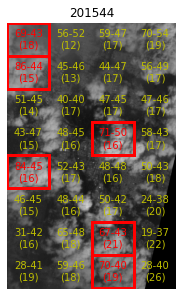

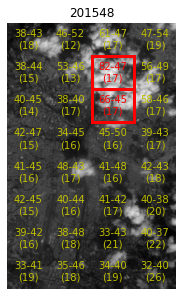

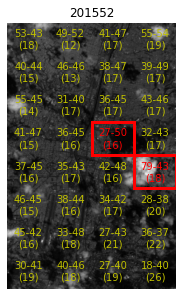

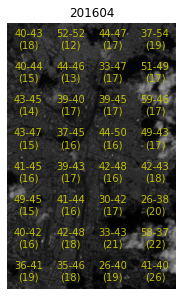

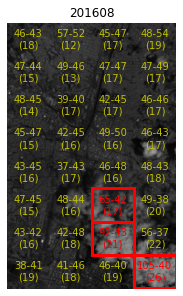

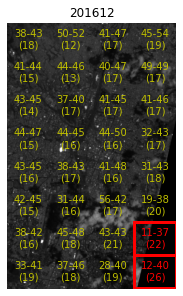

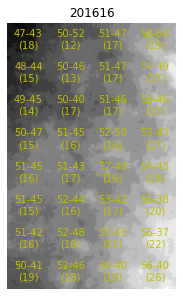

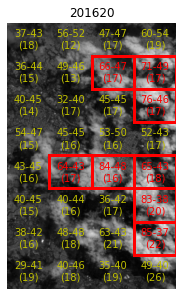

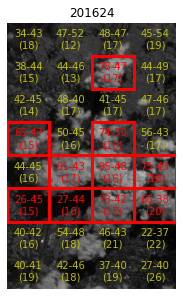

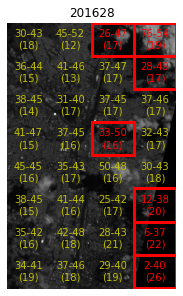

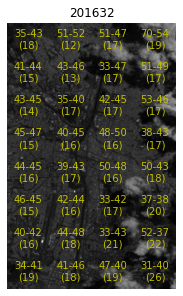

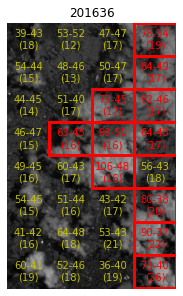

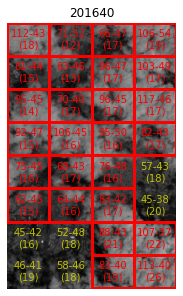

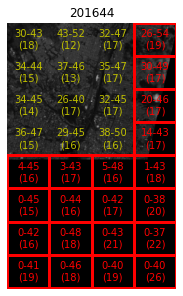

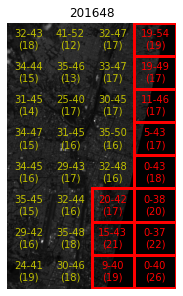

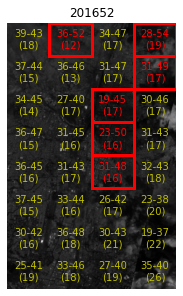

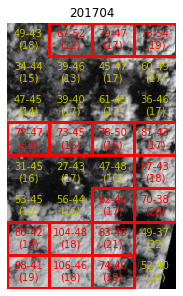

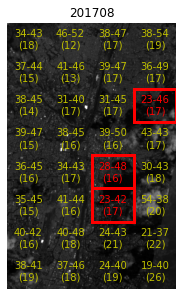

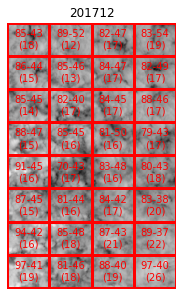

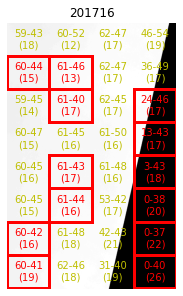

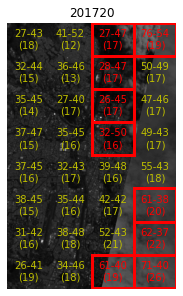

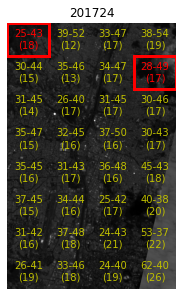

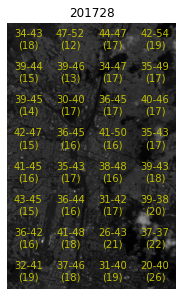

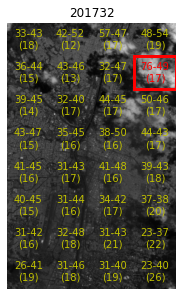

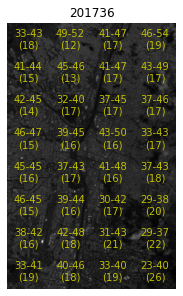

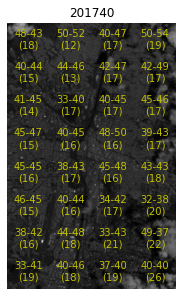

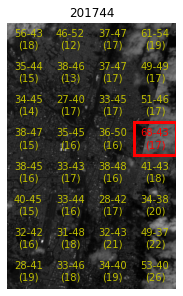

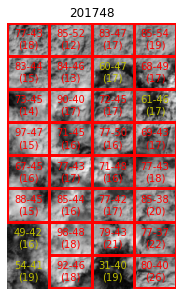

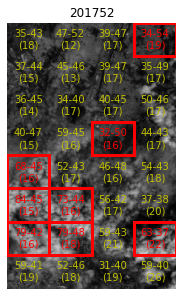

In [17]:
selected_band = 0
ratio_list = np.ones((tiles_in_band, 1))

all_index_in_band = selectWantedIndex(selected_band)
all_img_selected_win = []
swapped_ratio_list = []
counter = 0
num_of_tiles = len(avg_img_tiles)
threshold_list = calculateThreshold(ratio_list, tile_std)

for tiles, img, epiweek in zip(all_img_win, dic['image'], dic['epiweek']):
  updated_img_tiles = tiles.copy()
  removed_tiles_counter = 0
  swapped_index_list = []

  for i in range(num_of_tiles):
    threshold = threshold_list[i]
    current_tile_value = tiles[i]
    avg_tile_value = avg_img_tiles[i]

    if np.absolute(current_tile_value - avg_tile_value) > threshold:
      swapped_index_list.append(i)
      updated_img_tiles[i] = avg_tile_value
      removed_tiles_counter += 1

  if counter % 4 == 0:
    selected_img = selectWantedImage(selected_band, img)
    plotImgMaskRegion(all_index_in_band, selected_img, swapped_index_list, epiweek, tiles, threshold_list)
  counter += 1  

  all_img_selected_win.append(updated_img_tiles)
  ratio = removed_tiles_counter / num_of_tiles
  swapped_ratio_list.append(ratio)

In [18]:
print(len(all_img_selected_win))
print(len(swapped_ratio_list))
print(np.average(swapped_ratio_list))

113
113
0.15984513274336284


#### Show what the average training image looks like in different bands

Selected tile index to analyze: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


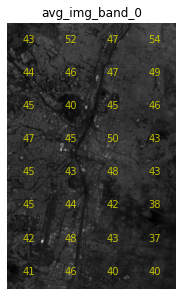

Selected tile index to analyze: [32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63]


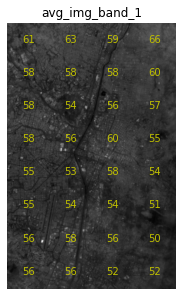

Selected tile index to analyze: [64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87
 88 89 90 91 92 93 94 95]


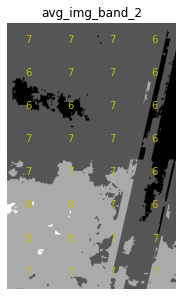

Selected tile index to analyze: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127]


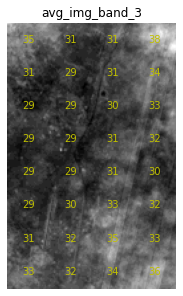

Selected tile index to analyze: [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]


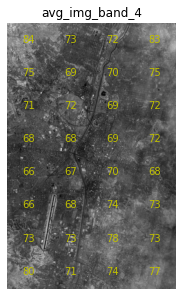

Selected tile index to analyze: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191]


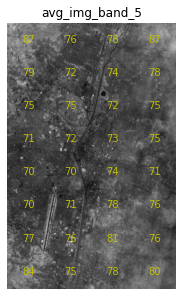

Selected tile index to analyze: [192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223]


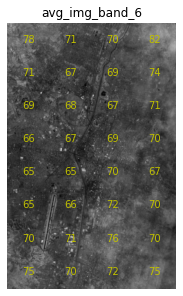

Selected tile index to analyze: [224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255]


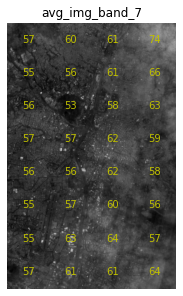

Selected tile index to analyze: [256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287]


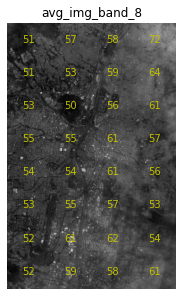

Selected tile index to analyze: [288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319]


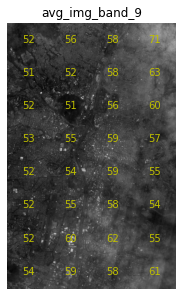

Selected tile index to analyze: [320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 350 351]


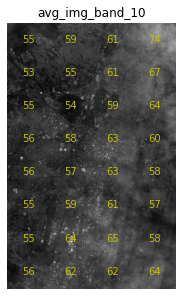

Selected tile index to analyze: [352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369
 370 371 372 373 374 375 376 377 378 379 380 381 382 383]


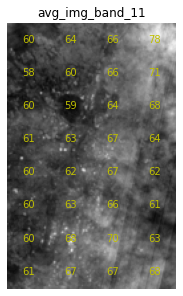

In [19]:
for i in range(12):
  all_index_in_band = selectWantedIndex(i)
  plotImgMaskRegion(all_index_in_band, selectWantedImage(i, avg_img), [], 'avg_img_band_' + str(i), avg_img_tiles, threshold_list)

#### Correlation & covariance

(12, 32)


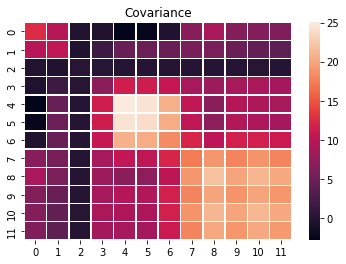

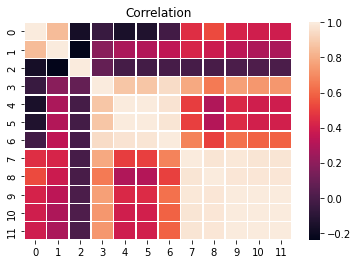

In [20]:
img_folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset/analysis/'
real_avg_img = tifffile.imread(img_folder + "average_img.tiff")

height, width, band = real_avg_img.shape
real_avg_win = splitImagesIntoTiles(real_avg_img, int(height/height_split), int(width/width_split)) 

reshaped_avg_win = real_avg_win.reshape((12, -1))
print(reshaped_avg_win.shape)

import seaborn as sns
cov = np.cov(reshaped_avg_win)
ax = sns.heatmap(cov, linewidth=0.5)
plt.title('Covariance')
plt.show()

corr = np.corrcoef(reshaped_avg_win)
ax = sns.heatmap(corr, linewidth=0.5)
plt.title('Correlation')
plt.show()

### LSTM

#### Setup

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import  mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [(f'var({j+1})') for j in range(n_vars)]
    else:
      names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]

  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)

  return agg

In [23]:
def removeLastWeek(data, n_features):
  return data[:,:-n_features]

In [24]:
def evalModel(X_train, X_test, y_train, y_test, scaler):
  tf.random.set_seed(1)

  # design network
  model = Sequential()
  model.add(LSTM(60, input_shape=(X_train.shape[1], 
                                  X_train.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')

  history = model.fit(X_train, y_train, epochs=50, verbose=0, batch_size=72, 
                      validation_data=(X_test, y_test))
  
  
  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()


  # make a prediction
  yhat = model.predict(X_test)
  yhat = scaler.inverse_transform(yhat)
  y_test = scaler.inverse_transform(y_test)
  mae = mean_absolute_error(y_test, yhat)
  print('Test MAE: %.3f' % mae)

  data_predict = yhat.reshape(len(yhat), 1) # predicted target cases
  dataY_plot = y_test.reshape(len(y_test), 1) # real test-target cases

  plt.plot(dataY_plot, label = 'actual')
  plt.plot(data_predict, label = 'predicted')
  plt.legend(loc="upper left")
  plt.suptitle('Time-Series Prediction')
  plt.show()

#### Main

In [25]:
X = np.array(all_img_selected_win)
scaler = MinMaxScaler(feature_range=(0, 1)) 
y = scaler.fit_transform(dic['cases'].reshape(-1, 1)) 
print(X.shape, y.shape)

(113, 384) (113, 1)


In [31]:
train_val_ratio = 0.8
train_num = int(len(y) * train_val_ratio)

X_train = X[:train_num,:]
X_test = X[train_num:,:]
y_train = y[:train_num]
y_test = y[train_num:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(list(y_train))
print(list(y_test))

(90, 384) (23, 384) (90, 1) (23, 1)
[array([0.15397924]), array([0.18512111]), array([0.15743945]), array([0.14359862]), array([0.20934256]), array([0.20069204]), array([0.23010381]), array([0.30103806]), array([0.35813149]), array([0.38235294]), array([0.44982699]), array([0.41176471]), array([0.42906574]), array([0.44982699]), array([0.43598616]), array([0.38062284]), array([0.42214533]), array([0.44636678]), array([0.30276817]), array([0.38581315]), array([0.44636678]), array([0.56747405]), array([0.5]), array([0.61937716]), array([0.58650519]), array([0.56920415]), array([0.69723183]), array([0.74913495]), array([0.77854671]), array([0.78373702]), array([0.79584775]), array([0.86678201]), array([0.88754325]), array([0.88754325]), array([0.8650519]), array([1.]), array([0.88581315]), array([0.7733564]), array([0.80276817]), array([0.84256055]), array([0.8200692]), array([0.9083045]), array([0.78200692]), array([0.66782007]), array([0.62975779]), array([0.56747405]), array([0.5432526

Final input: (80, 10, 384) (13, 10, 384)
------------------------------------------
Final output: (80, 1) (13, 1)


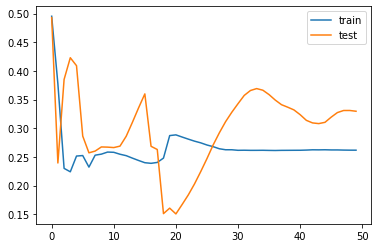

Test MAE: 190.540


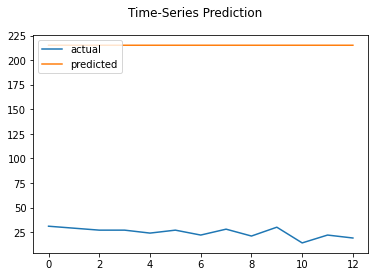

In [32]:
# frame as supervised learning
weeks = 10
train = series_to_supervised(X_train, n_in=weeks)
test = series_to_supervised(X_test, n_in=weeks)

n_features = X.shape[1]
train_np, test_np = train.to_numpy(), test.to_numpy()

clean_train = removeLastWeek(train_np, n_features)
clean_test = removeLastWeek(test_np, n_features)

final_X_train = clean_train.reshape((-1, weeks, n_features))
final_X_test = clean_test.reshape((-1, weeks, n_features))
print('Final input:', final_X_train.shape, final_X_test.shape)

print('------------------------------------------')
final_y_train = y_train[weeks:]
final_y_test = y_test[weeks:]
print('Final output:', final_y_train.shape, final_y_test.shape)

evalModel(final_X_train, final_X_test, final_y_train, final_y_test, scaler)

In [ ]:
#https://github.com/MITCriticalData-Colombia/Dengue-MetaData/blob/fusion_time_series/multi_var_time_series/LSTM_multivariate_v2_weekly_temperature.ipynb

### HTML with Colab

In [ ]:
from IPython.display import HTML, display
from google.colab import output

result_html = """
    <h1>Hello</h1>
  """
display(HTML(result_html))